In [458]:
import csv
import random
import pandas as pd
import numpy as np
from random import sample
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import defaultdict
from collections import Counter
from sklearn.cluster import KMeans
from j2v import mag, w2v, predict, util
from scipy.stats import ttest_ind
from scipy.spatial.distance import cosine
import clusim.sim as sim
from clusim.clustering import Clustering
from itertools import combinations
from sklearn.metrics import cohen_kappa_score
%matplotlib inline

In [459]:
pd.options.mode.chained_assignment = None

In [460]:
dis_name_abbr = {'Brain Research': 'Brain', 'Medical Specialties': 'Med', 'Health Professionals': 'Health', 'Social Sciences': 'Social', 'Earth Sciences': 'Earth', 'Biology': 'Biology', 'Chemical, Mechanical, & Civil Engineering': 'Eng', 'Chemistry': 'Chem', 'Biotechnology': 'Biotech', 'Infectious Diseases': 'Infectious', 'Math & Physics': 'Math', 'Humanities': 'Hum', 'Electrical Engineering & Computer Science': 'EECS'}


In [461]:
model = w2v.load_j2v(mag.get_path('100feat_50minwords_10context_2016'))


model shape is: (20835, 100) 



In [5]:
mapping = mag.load_map_jid_discipline('journal_discipline_map.csv')

14113 journals in MAG's Journal.txt were matched to UCSD data, and 29 of them are interdisciplinary journals in UCSD catelog.


In [203]:
vid2vname = mag.get_venue_dict(key='id')
vname2vid = mag.get_venue_dict(key='name')

processing /l/nx/data/haopeng/j2v/Journals.txt...
finished processing!

processing /l/nx/data/haopeng/j2v/Conferences.txt...
finished processing!

processing /l/nx/data/haopeng/j2v/Journals.txt...
finished processing!

processing /l/nx/data/haopeng/j2v/Conferences.txt...
finished processing!



## Element-wise similarity scores

In [6]:
data, new_data = predict.prepare_data(model, mapping)

data length: 12780, new_data length: 8055


In [7]:
del new_data

In [9]:
data = data.loc[data.disc_name!='Interdiscipline']
data.index = range(len(data))

In [29]:
data.shape

(12751, 4)

In [28]:
data.head()

,jid,vec,disc_name,disc_id
0,07A4F1E7,"[-0.0012872595, -0.0853514, 0.07630906, -0.150...",Electrical Engineering & Computer Science,7
1,0837204E,"[-0.07732971, -0.04124106, -0.0265404, -0.1606...",Medical Specialties,3
2,0AF80E42,"[0.09048805, -0.14503312, -0.1512347, -0.16372...",Social Sciences,13
3,0B51FE5C,"[-0.14837122, -0.018957704, 0.046735425, -0.03...",Medical Specialties,3
4,08DE9C2C,"[0.042609222, -0.030718075, 0.09757196, 0.2079...",Biology,1


In [70]:
centroids = []

for ix, gp in data.groupby('disc_id'):
    c_vec = np.mean(np.array((gp.vec.tolist())), axis = 0)
    # c_vec /= np.linalg.norm(c_vec)
    centroids.append(c_vec)
    
centroids = np.array(centroids)

In [71]:
centroids.shape

(13, 100)

In [106]:
kmeans = KMeans(n_clusters=len(centroids), init=centroids, n_init=1, random_state=0).fit(np.array((data.vec.tolist())))

In [107]:
kmeans.labels_

array([10,  2,  8, ..., 12, 10, 10], dtype=int32)

In [162]:
len(kmeans.labels_)

12751

In [109]:
# https://hoosier-clusters.github.io/clusim/html/clusim.html#id15
    
C_ucsd, C_j2v = dict(), dict()

for jid, g1, g2 in zip(data.jid, data.disc_id, kmeans.labels_):
#     C_ucsd[jid] = [disc_group_map[g1]]
    C_ucsd[jid] = [g1]
    C_j2v[jid] = [g2]
    
C_ucsd = Clustering(elm2clu_dict = C_ucsd)
C_j2v = Clustering(elm2clu_dict = C_j2v)

In [38]:
elementScores, relabeled_elements = sim.element_sim_elscore(C_ucsd, C_j2v, alpha = 0.9)

In [112]:
np.max(elementScores)

0.6000000000000001

In [452]:
np.min(elementScores)

0.0006821282401089368

In [114]:
jid_disc = dict(zip(data.jid, data.disc_name))

In [125]:
disc_jid_scores = defaultdict(list)

for jid, ix in relabeled_elements.items():
    score = elementScores[ix]
    disc_jid_scores[jid_disc[jid]].append((vid2vname[jid], score))

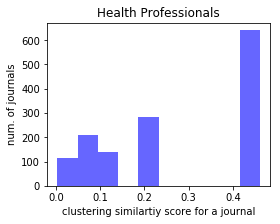

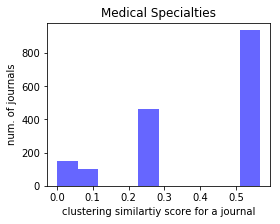

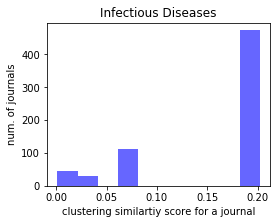

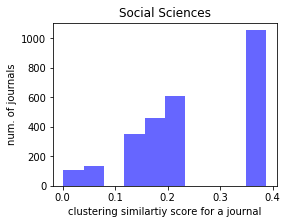

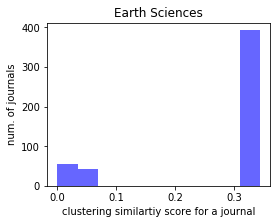

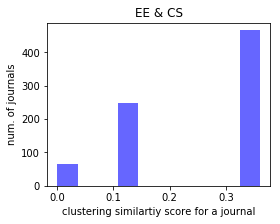

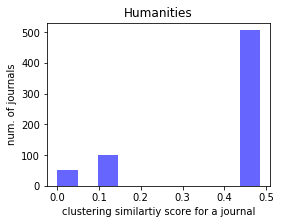

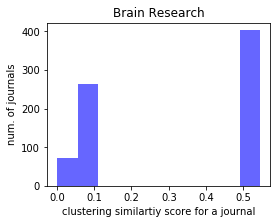

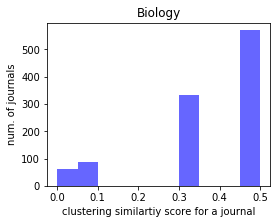

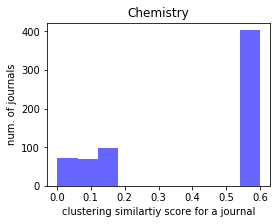

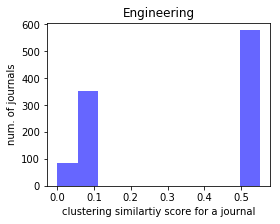

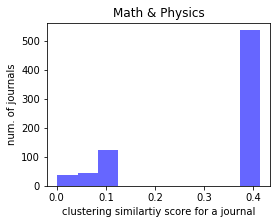

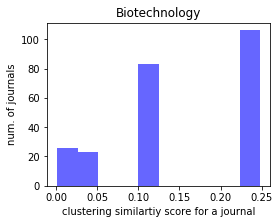

In [453]:
disc_abbr = {'Chemical, Mechanical, & Civil Engineering': 'Engineering',
             'Electrical Engineering & Computer Science': 'EE & CS'}

for disc in disc_jid_scores:
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.hist([score for jid, score in disc_jid_scores[disc]], bins = 10, facecolor='blue', alpha=0.6)
    ax.set_xlabel('clustering similartiy score for a journal')
    ax.set_ylabel('num. of journals')
    title = disc
    if disc in disc_abbr:
        title = disc_abbr[disc]
    ax.set_title('%s'%title)
    fig.savefig('%s_simi_dist.pdf'%dis_name_abbr[disc], bbox_inches='tight', pad_inches=0)
    plt.show()

In [394]:
disc = 'Social Sciences'

# bottome 10
sorted(disc_jid_scores[disc], key=lambda x: x[1])[:10]

[('Statistica Sinica', 0.00147492625368717),
 ('Biochemistry and Molecular Biology Education', 0.00147492625368717),
 ('Cell Biology Education', 0.00147492625368717),
 ('Biostatistics', 0.00147492625368717),
 ('Foundations of Chemistry', 0.0022123893805308104),
 ('Environmental Progress', 0.0022123893805308104),
 ('Journal of The Society of Leather Technologists and Chemists',
  0.0022123893805308104),
 ('Dissolution Technologies', 0.0022123893805308104),
 ('Journal of Chemical Education', 0.0022123893805308104),
 ('Biochemical Education', 0.0022123893805308104)]

In [395]:
# top 10
sorted(disc_jid_scores[disc], key=lambda x: x[1])[-10:]

[('Economia Chilena', 0.387905604719764),
 ('Journal of Personal Selling and Sales Management', 0.387905604719764),
 ('Economia Mexicana-nueva Epoca', 0.387905604719764),
 ('Politicka Ekonomie', 0.387905604719764),
 ('Journal of Economics Theory', 0.387905604719764),
 ('Cuadernos De Economia Y Direccion De La Empresa', 0.387905604719764),
 ('Academia-revista Latinoamericana De Administracion', 0.387905604719764),
 ('European Integration Online Papers-eiop', 0.387905604719764),
 ('Amfiteatru Economic', 0.387905604719764),
 ('Innovar-revista De Ciencias Administrativas Y Sociales', 0.387905604719764)]

## Survey analysis

Pretest (randomly select 10 from both the top 100 and the bottom 100 journals)

In [269]:
jname_top_bottom_dict = {}
for disc in disc_jid_scores:
    results = []
    top100 = sorted(disc_jid_scores[disc], key=lambda x: x[1])[-100:]
    bot100 = sorted(disc_jid_scores[disc], key=lambda x: x[1])[:100]
    for jname, score in top100:
        jname_top_bottom_dict[jname] = 'top'
    for jname, score in bot100:
        jname_top_bottom_dict[jname] = 'bottom'
    results.extend(sample(top100, 10))
    results.extend(sample(bot100, 10))
    random.shuffle(results)

    with open('%s.csv'%dis_name_abbr[disc], 'w') as f:
        writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["Journal in %s"%disc, "response (correct:1 and incorrect: 0)"])
        for journal, score in results:
            writer.writerow([journal, ""])

In [270]:
len(jname_top_bottom_dict)

2600

In [408]:
survey_df = pd.read_csv('./journal_category_evaluation.csv')

In [409]:
def get_vote(row):
    r1, r2, r3 = row['Response 1'], row['Response 2'], row['Response 3']
    li = [r1, r2, r3]
    r, cn = Counter(li).most_common()[0]
    if cn >= 2:
        return r
    else:
        return None # for three different inputs

In [410]:
survey_df = survey_df.replace({-2: 1})

In [411]:
survey_df['Response'] = survey_df.apply(get_vote, axis=1)
survey_df['rank'] = survey_df.Journal.map(jname_top_bottom_dict)

In [412]:
ks = []
for r1, r2 in combinations(['Response 1', 'Response 2', 'Response 3'], r=2):
    kappa = cohen_kappa_score(survey_df[r1], survey_df[r2])
    ks.append(kappa)
    print(r1, r2, ':\t', kappa)

Response 1 Response 2 :	 0.7307692307692308
Response 1 Response 3 :	 0.5217391304347826
Response 2 Response 3 :	 0.5249406175771971


In [413]:
np.mean(ks)

0.5924829929270702

In [334]:
for disc, gp in survey_df.groupby('Discipline'):
    print(disc)
    for rank, subgp in gp.groupby('rank'):
        total = np.sum(~subgp.majority_vote.isna())
        correct = np.sum(subgp.majority_vote == 1)
        print('\t%s:%d/%d=%f'%(rank, correct, total, correct/total))

Chemical, Mechanical, & Civil Engineering
	bottom:5/10=0.500000
	top:9/10=0.900000
Electrical Engineering & Computer Science
	bottom:8/10=0.800000
	top:9/10=0.900000
Social Sciences
	bottom:3/10=0.300000
	top:10/10=1.000000


Post test

In [379]:
exclude_j = set(survey_df.Journal)

In [418]:
for disc in set(survey_df.Discipline):
    print(disc)
    top100 = sorted(disc_jid_scores[disc], key=lambda x: x[1])[-100:]
    bot100 = sorted(disc_jid_scores[disc], key=lambda x: x[1])[:100]
    top100 = [jj for jj, sc in top100 if jj not in exclude_j]
    bot100 = [jj for jj, sc in bot100 if jj not in exclude_j]
    top_results = sample(top100, 30)
    bot_results = sample(bot100, 30)
    for i in range(3):
        results = []
        results.extend(top_results[i*10:(i+1)*10])
        results.extend(bot_results[i*10:(i+1)*10])
        random.shuffle(results)
        with open('%s_%d.csv'%(dis_name_abbr[disc], i), 'w') as f:
            writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(["Journal in %s"%disc, "rank"])
            for journal in results:
                writer.writerow([journal, jname_top_bottom_dict[journal]])
    print()

In [424]:
post_df = pd.read_csv('./post_journal_evaluation.csv')

In [425]:
post_df = post_df.loc[post_df.Response != -1]

In [427]:
post_df = post_df.replace({-2: 1})

In [428]:
post_df['rank'] = post_df.Journal.map(jname_top_bottom_dict)

In [439]:
# combine pre and post
post_df = pd.concat([post_df, survey_df[['Discipline', 'Journal', 'Response', 'rank']]], ignore_index=True, sort=False)

In [440]:
for disc, gp in post_df.groupby('Discipline'):
    print(disc)
    two_li = []
    for rank, subgp in gp.groupby('rank'):
        two_li.append(subgp.Response.tolist())
        # to get rid of total disagreement in pre-test responses (for which we take the majority vote)
        total = np.sum(~subgp.Response.isna())
        correct = np.sum(subgp.Response == 1)
        print('\t%s:%d/%d=%f'%(rank, correct, total, correct/total))
    print('\t', ttest_ind(two_li[0], two_li[1]))

Chemical, Mechanical, & Civil Engineering
	bottom:27/40=0.675000
	top:37/39=0.948718
	 Ttest_indResult(statistic=-3.2671239802018763, pvalue=0.0016240981602172267)
Electrical Engineering & Computer Science
	bottom:23/40=0.575000
	top:38/39=0.974359
	 Ttest_indResult(statistic=-4.749701111192256, pvalue=9.251933417565973e-06)
Social Sciences
	bottom:25/39=0.641026
	top:39/40=0.975000
	 Ttest_indResult(statistic=-4.128665429195408, pvalue=9.170407710983618e-05)


In [635]:
# import bootstrapped.bootstrap as bs
# import bootstrapped.stats_functions as bs_stats

def boot_mean(sample, rep = 5000):
    result = []
    for i in range(rep):
        re_sam = np.random.choice(sample, size=len(sample), replace=True)
        result.append(np.mean(re_sam))
    lci, uci = np.percentile(result, q=[2.5, 97.5])
    return (np.mean(result), (lci, uci))

In [640]:
means = [[], []]
confs = [[], []]
discs = []
for disc, gp in post_df.groupby('Discipline'):
    print(disc)
    discs.append(disc)
    for rank, subgp in gp.groupby('rank'):
        sample = subgp.Response == 1
        sample = np.array(sample.astype(int))
        # res = bs.bootstrap(sample, stat_func = bs_stats.mean, alpha=0.05, num_iterations=10000)
        u, (lci, uci) = boot_mean(sample)
        if rank == 'top':
            means[0].append(u)
            confs[0].append([u - lci, uci - u])
        if rank == 'bottom':
            means[1].append(u)
            confs[1].append([u - lci, uci - u])
        print('\t%s: %f (%f, %f)'%(rank, u, lci, uci))

Chemical, Mechanical, & Civil Engineering
	bottom: 0.674455 (0.525000, 0.825000)
	top: 0.948918 (0.871795, 1.000000)
Electrical Engineering & Computer Science
	bottom: 0.577845 (0.425000, 0.725000)
	top: 0.973944 (0.923077, 1.000000)
Social Sciences
	bottom: 0.641974 (0.487179, 0.794872)
	top: 0.974410 (0.925000, 1.000000)


In [638]:
dis_name_abbr = {'Social Sciences': 'Social Sciences', \
                 'Chemical, Mechanical, & Civil Engineering': 'Engineering',\
                 'Electrical Engineering & Computer Science': 'EE & CS'}

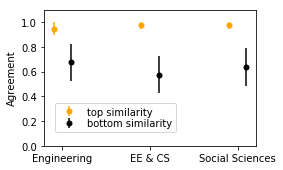

In [639]:
# cols = ['#ffa500', '#2500ff', '_']

step = 5
xs_1 = 1 + np.arange(3) * step
xs_2 = 2 + np.arange(3) * step
pos = 1.5 + np.arange(3) * step

fig, ax = plt.subplots(figsize = (3.8, 2.5))

ax.errorbar(xs_1, means[0], yerr=np.array(confs[0]).T, color='#ffa500', fmt='o', markersize=5, label='top similarity')
ax.errorbar(xs_2, means[1], yerr=np.array(confs[1]).T, color='k', fmt='o', markersize=5, label='bottom similarity')
legend = ax.legend(loc=[0.05, 0.1], numpoints=1, labelspacing = 0.15, shadow=False, frameon = True)
ax.set_xticks(pos)
ax.set_xticklabels([dis_name_abbr[disc] for disc in discs], rotation=0, ha='center')
ax.set_ylabel('Agreement')
ax.set_ylim([0, 1.1])
plt.show()
fig.savefig('top_bottom_accuracy.pdf', bbox_inches='tight', pad_inches=0)

## Plot clustering similarity scores

In [183]:
points = pd.read_csv(mag.get_path('jid_2d_projection.csv'), header = 0)

In [184]:
points = points.loc[points.jid.isin(relabeled_elements)]
points.index = range(len(points))

In [185]:
points['similarity_score'] = points['jid'].apply(lambda iid: elementScores[relabeled_elements[iid]])

In [188]:
min_c = min(points.similarity_score)
max_c = max(points.similarity_score)

def cosine_to_grayscale_hex(row):
    gray = (row['similarity_score'] - min_c) / (max_c - min_c)
    return colors.rgb2hex((gray, gray, gray))

In [191]:
points['gray_color'] = points.apply(lambda row: cosine_to_grayscale_hex(row), axis=1)

In [192]:
points.head(2)

,jid,x,y,hex_color,similarity_score,gray_color
0,07A4F1E7,0.087706,0.597490,#fb01ff,0.359907,#999999
1,0837204E,0.890809,0.485782,#FF0000,0.566667,#f1f1f1


In [205]:
elementScores[relabeled_elements[vname2vid['Journal of The Audio Engineering Society']]]

0.11843361986628465

In [206]:
elementScores[relabeled_elements[vname2vid['Homme']]]

0.4851104707012488

In [477]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_map_left(ax, points, s = 3):
    points = points.set_index(['jid'])
    X = (points.loc[:, ['x', 'y']]).values
    # scores = points['gray_color'].tolist()
    scores = np.array(points['similarity_score'].tolist()) * -1
    sc = ax.scatter(X[:, 0], X[:, 1], s = s, c = scores, cmap = 'Greys', alpha = 1.0, linewidths = 0)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.set_axis_off()
    return sc

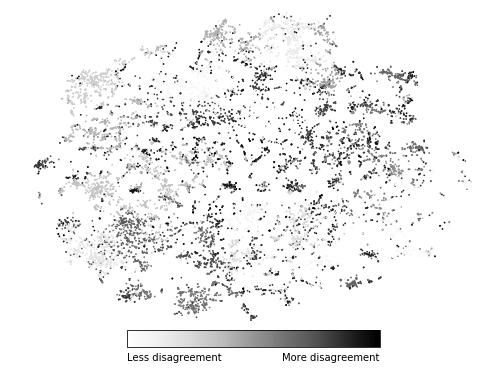

In [515]:
fig, ax = plt.subplots(figsize=(8, 6.2))
sc = plot_map_left(ax, points)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad="2%")
# cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", aspect=15, fraction=0.05, pad=0.02)
cbar.ax.set_axis_off()
cbar.ax.text(0, -0.8, 'Less disagreement')
cbar.ax.text(0.615, -0.8, 'More disagreement')
plt.show()
fig.savefig('map_cluster_simi_score.pdf', bbox_inches='tight', pad_inches=0)